In [194]:
%load_ext autoreload
%autoreload 2
import site
import sys
site.addsitedir('..')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [581]:
import numpy as np
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project, rotate
from src.interpolate import *

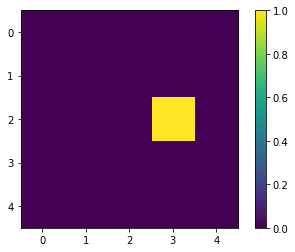

In [616]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)
plt.imshow(v[:,:,2]); plt.colorbar()

angles = np.array([0,0,np.pi/8])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


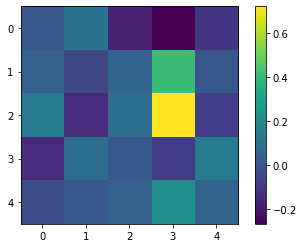

In [617]:

# First ifftshift in the spatial domain 
v = np.fft.ifftshift(v)
V, X, Y, Z, _, _, _ = volume_fourier(v, dimensions)

Vs, slice_X, slice_Y, slice_Z = project(V, X, Y, Z, angles, "nn")

vsi = np.fft.ifftn(Vs)
plt.imshow(np.real(np.fft.fftshift(vsi)))
plt.colorbar()
print(np.imag(vsi))

### Step by step inside the project function

In [578]:
nx = 5
shape = np.array([nx, nx, nx])
dimensions = np.array([1, 1, 1])
radius = 1/(2*nx)
centre = np.array([0.2,0,0])
intensity = 1

v = spherical_volume(shape, dimensions, centre, radius, intensity, False)

v = np.fft.ifftshift(v)

V, X, Y, Z, _, _, _ = volume_fourier(v, dimensions)

angles = np.array([0,0,np.pi/4])

#plt.imshow(v[:,:,0]); plt.colorbar()

[[ 0.00000000e+00  2.22044605e-17  5.55111512e-18 -5.55111512e-18
  -2.22044605e-17]
 [-2.44714770e-18 -1.91873597e-17 -1.22808287e-18  7.75381008e-18
   1.79637859e-17]
 [ 3.95956816e-18  8.84133972e-18 -3.56403530e-18 -6.99481312e-18
  -6.86155564e-18]
 [-3.95956816e-18  4.88177156e-18  6.99481312e-18  3.56403530e-18
  -6.86155564e-18]
 [ 2.44714770e-18 -1.67402120e-17 -7.75381008e-18  1.22808287e-18
   1.79637859e-17]]


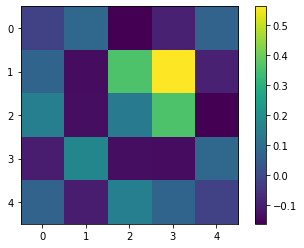

In [579]:
# Rotate coordinates

Xr, Yr, Zr = rotate(X, Y, Z, angles)
slice_coords = np.array([Xr[:,:,0].flatten(),Yr[:,:,0].flatten(),Zr[:,:,0].flatten()])

# Get x_freq, etc
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# Interpolate and reshape
Vr0_flat = interpolate(slice_coords, x_freq, y_freq, z_freq, V, "tri")
Vr0 = Vr0_flat.reshape(5,5)

# Inverse Fourier transform
vr0 = np.fft.ifftn(Vr0)
plt.imshow(np.real(np.fft.fftshift(vr0)))
plt.colorbar()

print(np.imag(vr0))

## The same, analytically

In [16]:
# Fourier transform of a 5 x 5 x 5 cube v with v[3,2,2] = 1 and 0 otherwise.

krange = np.arange(5)
x, y, z = np.meshgrid(krange, krange, krange)
V_a = np.exp(-1j * 2 * np.pi / 5 * (3*x + 2*y + 2*z))
#plt.imshow(np.real(V_a[:,:,0])); plt.colorbar()

In [17]:
# And it's the same as the numerical V

np.max(abs(V - V_a))

1.355199909595506e-15

Given X and Y above, the rotated coordinates of the plane z=0 are

In [18]:
Xr0_a = np.array([np.zeros(5), -1*np.ones(5), -2*np.ones(5), 2*np.ones(5), 1*np.ones(5)])
Xr0_a

array([[ 0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1.],
       [-2., -2., -2., -2., -2.],
       [ 2.,  2.,  2.,  2.,  2.],
       [ 1.,  1.,  1.,  1.,  1.]])

In [19]:
Yr0_a = np.array([0, 1, 2, -2, -1])*np.ones([5,1])
Yr0_a

array([[ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.],
       [ 0.,  1.,  2., -2., -1.]])

In [20]:
Zr0_a = np.zeros([5,5])

In [21]:
# And these are also the same as what the function rotate returns

print(np.max(abs(Xr0_a - Xr[:,:,0])))
print(np.max(abs(Yr0_a - Yr[:,:,0])))
print(np.max(abs(Zr0_a - Zr[:,:,0])))

4.0
4.0
0.0


In [22]:
# Evaluate V at points given by Xr0_a, Yr0_a, Zr0_a to obtain Vr0_a

Vr0_a = np.exp(-1j * 2 * np.pi/5 * (3 * Xr0_a + 2 * Yr0_a + 2 * Zr0_a))

In [23]:
# And they're the same....WEIRD

np.max(abs(Vr0 - Vr0_a))

1.9021130325903073

In [24]:
# Calculate the IFFT 
k_freqs = np.arange(5)
K1, K2 = np.meshgrid(k_freqs, k_freqs)
K3 = np.zeros(K1.shape)

K1r, K2r, K3r = rotate(K1, K2, K3, angles)

vr0_a = np.ones([5,5])*0j
for i in range(5):
    for j in range(5):
        vr0_a[j,i] = 1/25 * np.sum(
            np.exp(1j * 2 * np.pi / 5 * (i * K1 + j * K2)) 
            * Vr0_a
        )

        

In [25]:
# Weirdly it's equal with the numerically calculated image
np.max((abs(vr0-vr0_a)))

1.0000000000000002

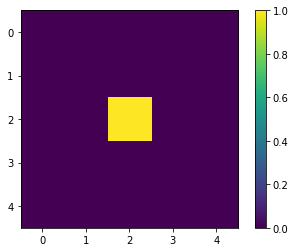

In [26]:
plt.imshow(np.real(vr0_a))
plt.colorbar()

## Analytical calculation, more direct

In [392]:
Kx = np.array([[0,0,0,0,0],[1,1,1,1,1],[2,2,2,2,2],[-2,-2,-2,-2,-2],[-1,-1,-1,-1,-1]])
Ky = Kx.T

In [393]:
Kx = np.fft.fftshift(Kx)
Kx

array([[-2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2]])

In [394]:
Ky = np.fft.fftshift(Ky)
Ky

array([[-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2]])

In [395]:
gamma = np.pi/2

R = np.array([[np.cos(gamma), -np.sin(gamma)],
            [np.sin(gamma), np.cos(gamma)]])

rc = []
for x, y in zip(Kx.flatten(), Ky.flatten()):
    xy2 = R @ np.array([x,y])
    rc.append(list(xy2))

rc = np.array(rc)  

Kxr = rc[:,0].reshape(Kx.shape)
Kyr = rc[:,1].reshape(Ky.shape)



In [396]:
#Kxr = np.fft.fftshift(Kxr)
#Kyr = np.fft.fftshift(Kyr)

In [397]:
Kxr

array([[ 2.0000000e+00,  1.0000000e+00, -1.2246468e-16, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00, -6.1232340e-17, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  0.0000000e+00, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  6.1232340e-17, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  1.2246468e-16, -1.0000000e+00,
        -2.0000000e+00]])

In [398]:
Kyr

array([[-2.0000000e+00, -2.0000000e+00, -2.0000000e+00, -2.0000000e+00,
        -2.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00,
        -1.0000000e+00],
       [-1.2246468e-16, -6.1232340e-17,  0.0000000e+00,  6.1232340e-17,
         1.2246468e-16],
       [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00],
       [ 2.0000000e+00,  2.0000000e+00,  2.0000000e+00,  2.0000000e+00,
         2.0000000e+00]])

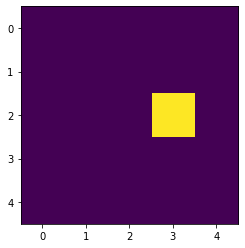

In [402]:


vr = np.zeros([5,5], dtype = np.complex128)
for i in range(5):
    for j in range(5):
        vr[i,j] = 1/25 * np.sum(
            np.exp(1j * 2 * np.pi/5* 
                # When fftshifted, the indices (3,2) become (0, 4)
                #(i * Kx + j * Ky - 3 * Kxr - 2 * Kyr) 
                (i * Kx + j * Ky - 0 * Kxr - 4 * Kyr) 

            )
        )

plt.imshow(np.real(np.fft.ifftshift(vr)))
#plt.imshow(np.real(vr))

In [389]:
Kx

array([[-2, -2, -2, -2, -2],
       [-1, -1, -1, -1, -1],
       [ 0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2]])

In [379]:
Kxr

array([[ 2.0000000e+00,  1.0000000e+00, -1.2246468e-16, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00, -6.1232340e-17, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  0.0000000e+00, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  6.1232340e-17, -1.0000000e+00,
        -2.0000000e+00],
       [ 2.0000000e+00,  1.0000000e+00,  1.2246468e-16, -1.0000000e+00,
        -2.0000000e+00]])

In [380]:
Ky

array([[-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2],
       [-2, -1,  0,  1,  2]])

In [381]:
Kyr

array([[-2.0000000e+00, -2.0000000e+00, -2.0000000e+00, -2.0000000e+00,
        -2.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, -1.0000000e+00,
        -1.0000000e+00],
       [-1.2246468e-16, -6.1232340e-17,  0.0000000e+00,  6.1232340e-17,
         1.2246468e-16],
       [ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
         1.0000000e+00],
       [ 2.0000000e+00,  2.0000000e+00,  2.0000000e+00,  2.0000000e+00,
         2.0000000e+00]])